In [147]:
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import pylab,random,cPickle
import matplotlib.pyplot as plt
from os import system,listdir
from scipy.cluster.hierarchy import fcluster,linkage,cophenet
from IPython.display import display, HTML
from os.path import join,dirname,basename,isdir

global familymatching_thresh
global enough_PE2barcode_numthresh 
global pe2readthresh 
global cellname_col 
global totalread_col 
global pe2read_col 
global barcodelist_col 
global barcodecnt_col 
global barcodenum_col 
familymatching_thresh = 0
enough_PE2barcode_numthresh = 5
pe2readthresh = 10
cellname_col = 0
totalread_col = 1
pe2read_col = 2
barcodelist_col = 3
barcodecnt_col = 4
barcodenum_col = 5

## Preprocess

#### un-multiplexing analysis

Performan analysis on the number of reads corresponding to each of the 8 groups with code under 
```
/cluster/zeng/code/research/lineage/index_analysis
```

In [33]:
### Summarizing the analysis output
data= []
mynames = ['endo_t1_trans','undirect_t1_trans','endo_t2_trans','undirect_t2_trans',\
          'endo_t1_fth1','undirect_t1_fth1','endo_t2_fth1','undirect_t2_fth1','undetermined']
for idx in range(len(mynames)):
    mynames[idx] = str(idx+1)+'_'+mynames[idx]
for i in range(4):
    for j in range(1):
        with open(join('/cluster/zeng/code/research/lineage/index_analysis',\
                       'lane_'+str(i+1)+'_R'+str(j+1)+'_indexsummary')) as f:
            posdata = [float(x) for x in f]
        label = '_'.join(['lane'+str(i+1)])
        sumdata = float(sum(posdata))
        data += [ [posdata[idx],mynames[idx],label] for idx in range(len(posdata))]
        data += [ [posdata[idx]/sumdata,mynames[idx],label+'_pct'] for idx in range(len(posdata))]

datapd = pd.DataFrame(data,columns=['Value','Index','Label']).pivot('Index','Label','Value')
display(datapd)

Label,lane1,lane1_pct,lane2,lane2_pct,lane3,lane3_pct,lane4,lane4_pct
Index,,,,,,,,
1_endo_t1_trans,14524710,0.207710,14570768,0.203794,13383757,0.201104,13204060,0.198757
2_undirect_t1_trans,9402214,0.134456,9903809,0.138519,8755504,0.131560,8130544,0.122387
3_endo_t2_trans,5941281,0.084963,6221703,0.087020,5412467,0.081328,4434168,0.066746
4_undirect_t2_trans,237650,0.003399,282141,0.003946,235916,0.003545,207304,0.003120
5_endo_t1_fth1,2287483,0.032712,2540852,0.035538,2188699,0.032887,1869695,0.028144
6_undirect_t1_fth1,6233238,0.089138,6500198,0.090915,6164407,0.092626,5799872,0.087304
7_endo_t2_fth1,5553585,0.079419,5599672,0.078320,5246975,0.078841,5481010,0.082504
8_undirect_t2_fth1,5187264,0.074180,5155183,0.072103,5100603,0.076641,4685809,0.070534
9_undetermined,20560461,0.294024,20723293,0.289846,20063168,0.301468,22620612,0.340502


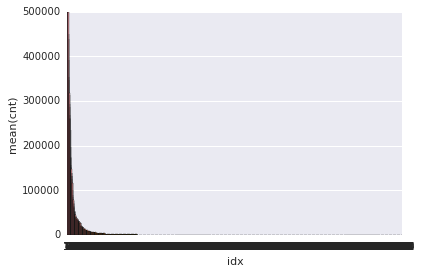

In [53]:
### Count distribution of the unmapped barcodes
with open(join('/cluster/zeng/code/research/lineage/index_analysis/unmapped.tsv')) as f:
    f.readline()
    thresh = 500000
    data = [float(x.split(',')[2]) for x in f]
    for idx in range(len(data)):
        if data[idx]> thresh:
            data[idx] = thresh
    data = pd.DataFrame([[idx,data[idx]]for idx in range(len(data))],columns=['idx','cnt'])
    sns.barplot(data=data,x='idx',y='cnt')

#### Split the reads
Split the reads into 8 groups by running
```
/cluster/zeng/code/research/lineage/splitreads/run_split_reads.sh
```

#### Run the indrop pipeline

Run 
```
/cluster/zeng/code/research/lineage/indrops_V2/run.py
```
The cutoff in the second part were determined using the following elbow-point analysis

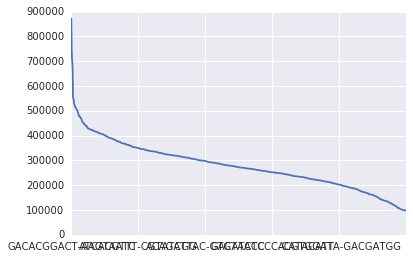

In [109]:
### Check Indrop preprocessing pipeline stats for the previous round
with open(join(t_topdir,'mESC','pre_split','barcode_read_counts.pickle'),'rb') as f:
    data = pd.Series(cPickle.load(f))
    data.sort_values(ascending=False)[:1000].plot()

,Total Reads,Frac. Valid,Valid Reads,Group
0,55683295,0.6281071908549952,34975078,1
1,36192071,0.56288356640326,20371922,2
2,22009619,0.6201914717378797,13650178,3
3,963011,0.508273529585851,489473,4
4,8886729,0.5635319812272884,5007956,5
5,24697715,0.6240795150482544,15413338,6
6,21881242,0.622645780344644,13624263,7
7,20128859,0.6609616074115279,13304403,8


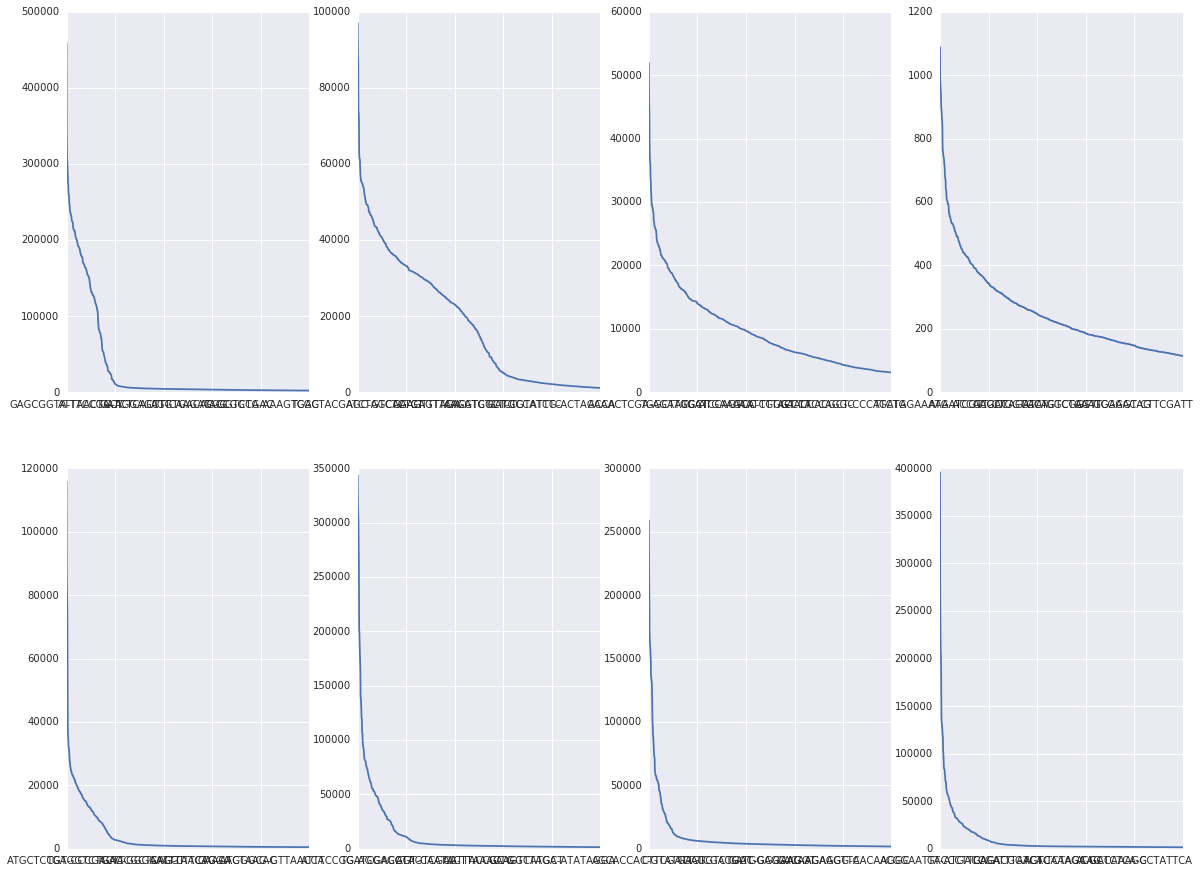

In [134]:
### Check Indrop preprocessing pipeline stats
t_topdir = '/cluster/zeng/research/lineage'
process_stats = []
fig, axs = plt.subplots(2, 4,figsize=(20, 15))
cutoff = [10000,4000,7000,200,3000,8000,8000,6000]
for i in range(8):
    with open(join(t_topdir,'mESC_new'+str(i+1),'pre_split','barcode_read_counts.pickle'),'rb') as f:
        data = pd.Series(cPickle.load(f))
    data.sort_values(ascending=False)[:1000].plot(ax=axs[i/4][i%4])
    #plt.figure()
    #data.sort_values(ascending=False)[:1000].plot()
    #plt.plot(range(1000), [cutoff[i]]*1000)
    with open(join(t_topdir,'mESC_new'+str(i+1),'stats/filtering_metrics.yaml')) as f:
        data = [x.strip().split(': ') for x in f]
        process_stats.append([ data[-3][1],data[-2][1],data[-1][1],i+1])

display(pd.DataFrame(process_stats,columns=['Total Reads','Frac. Valid','Valid Reads','Group']))

In [124]:
# check the number of cells (droplets) left with the above cutoffs
display(pd.DataFrame([ len([name for name in listdir('/cluster/zeng/research/lineage/mESC_new'\
                                                 +str(i+1)+'/post_split/filtered_fastq')
            if not isdir(join('/cluster/zeng/research/lineage/mESC_new'\
                                    +str(i+1)+'/post_split/filtered_fastq', name))]) for i in range(8)],columns=['#cell']))

,#cell
0,205
1,635
2,551
3,545
4,196
5,218
6,144
7,232


## Extract lineage barcode

Run 
```
/cluster/zeng/code/research/lineage/cell-lineage.py name_of_experiment 
```
where name_of_experiment should be one of the names specified in `/cluster/zeng/code/research/lineage/indrops_V2/run.py`

In [335]:
def listdist(seqs1,seqs2,dist_thresh):
    ### If any element of seqs1 matches any element of seq2, we call it a match
    for idx1 in range(len(seqs1)):
        for idx2 in range(len(seqs2)):
            t_dist = dist(seqs1[idx1],seqs2[idx2])
            if t_dist <= dist_thresh:
                return 0
    return 1

In [331]:
def analysis2(mappingfile,family_analysis,barcode2filter,family_suffix):

    ### Read the mapping result
    oridata = pd.read_csv(mappingfile,sep ='\t',dtype ={'barcodecnt':int,'barcode_moleculecnt':int,'readcnt':int,'moleculecnt':int})
    orioridata = oridata
    oridata['barcodes'] = oridata['barcodes'].apply(lambda x: np.asarray(x.split(',')))
    oridata['barcodereads_split'] = oridata['barcodereads_split'].apply(lambda x: np.asarray(map(int,x.split(','))))
    ori_barcode_coverage = pd.Series([ y for x in oridata['barcodes'] for y in x]).value_counts()
    ori_barcode_coverage.to_csv(mappingfile+'.barcodecoverage',sep='\t')
    
    ### For each cell, retain only the first two barcode with a threshold cutoff
    data = oridata
    for index, row in data.iterrows():
        t_bc_read_cnt = row['barcodereads_split']
        topick = [x for x in np.argsort(t_bc_read_cnt)[-2:][::-1] if t_bc_read_cnt[x]>pe2readthresh]
        if len(topick) == 2:
            if t_bc_read_cnt[topick[1]] < t_bc_read_cnt[topick[0]]/2.0:
                topick = [topick[0]]
        if len(topick)>0:
            data.set_value(index,'barcodes',row['barcodes'][topick])
            data.set_value(index,'barcodereads_split',t_bc_read_cnt[topick])
            data.set_value(index,'barcode_moleculecnt',sum(t_bc_read_cnt[topick]))
            data.set_value(index,'barcodecnt',len(topick))
        else:
            data.set_value(index,'barcodes',['\\'])
    data['barcodes'] = data['barcodes'].apply(lambda x:','.join(x))
    barcode_coverage = pd.Series([ y for x in data['barcodes'] for y in x.split(',')]).value_counts()
    barcode_coverage.to_csv(mappingfile+'.barcodecoverage.afterprocessing',sep='\t')
    bi_barcode_coverage = pd.Series([ ','.join(np.sort(x.split(','))) for x in data['barcodes'] ]).value_counts()
    bi_barcode_coverage.to_csv(mappingfile+'.barcodecoverage.afterprocessing.bi',sep='\t')
    
    stats= [['# of cells',len(oridata)],\
            ['# of barcodes',len(ori_barcode_coverage)],\
            ['# of cells after processing',len(data[data['barcodes']!= '\\'])],\
            ['# of barcodes after processing',len(barcode_coverage)],\
            ['# of barcodes after processing (concat two bc)',len(bi_barcode_coverage)],\
            ['# of reads',oridata['readcnt'].sum()],\
            ['# of transcript molecules',oridata['moleculecnt'].sum()],\
            ['# of transcript molecules w. bc',oridata['barcode_moleculecnt'].sum()],\
            ]
    summary = pd.DataFrame([[x[0],x[1]] for x in stats],columns=['Item','Num'])
    
    ### Family analysis
    family_summary = family2(data[data['barcodes']!= '\\'],mappingfile+'.familyanalysis'+family_suffix+'.csv') if family_analysis else None
        
    return summary,family_summary

In [353]:
def family2(data,outfile):
    num_data = len(data)
    data.index = range(num_data)
    
    cond_dist = [listdist(data.get_value(idx1,'barcodes').split(','),data.get_value(idx2,'barcodes').split(','),\
                          familymatching_thresh) for idx1 in range(num_data-1) for idx2 in range(idx1+1,num_data)]
    link = linkage(cond_dist,method='single')
    data['lineage'] = pd.Series(fcluster(link,0.5,criterion='distance')-1,index=data.index)
    data = data.sort_values(by='lineage')
    data.to_csv(outfile,index=False)
    
    stats= [['# of cells included in family analysis',num_data] ,\
            ['# of lineages',len(data['lineage'].unique())],\
            ['Size of lineages',list(data['lineage'].value_counts())]
             ]
    summary = pd.DataFrame([[x[0],x[1]] for x in stats],columns=['Item','Num'])
    return summary

In [354]:
### fth1 integrated barcodes
allsummary = None
allsummary_family = None
barcode2filter = [[],[],[],[]]
for idx, expt in enumerate(['mESC_fth1_time1_rep1','mESC_fth1_time1_rep2','mESC_fth1_time2_rep1','mESC_fth1_time2_rep2']):
    mappingfile = join('/cluster/zeng/research/lineage',expt,'post_split/cell-lineage_mapping_quality20_mismatch2_prefixsuffixtol2')
    t_s,t_family = analysis2(mappingfile,True,barcode2filter[idx],'')
    t_s.columns = ['Item',expt]
    t_family.columns = ['Item',expt]
    allsummary = t_s if allsummary is None else allsummary.merge(t_s,on='Item')
    allsummary_family = t_family if allsummary_family is None else allsummary_family.merge(t_family,on='Item')

display(allsummary)
display(allsummary_family)

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Item,mESC_fth1_time1_rep1,mESC_fth1_time1_rep2,mESC_fth1_time2_rep1,mESC_fth1_time2_rep2
0,# of cells,196,218,144,232
1,# of barcodes,16,385,118,308
2,# of cells after processing,8,217,143,232
3,# of barcodes after processing,2,14,7,12
4,# of barcodes after processing (concat two bc),2,18,7,17
5,# of reads,2998912,10967607,6146482,8027986
6,# of transcript molecules,173648,128075,135995,173619
7,# of transcript molecules w. bc,1912,63301,34007,105524


,Item,mESC_fth1_time1_rep1,mESC_fth1_time1_rep2,mESC_fth1_time2_rep1,mESC_fth1_time2_rep2
0,# of cells included in family analysis,8,217,143,232
1,# of lineages,1,9,4,6
2,Size of lineages,[8],"[165, 14, 11, 10, 6, 5, 3, 2, 1]","[132, 5, 4, 2]","[211, 11, 5, 3, 1, 1]"


In [344]:
### fth1 barcodelet
allsummary = None
allsummary_family = None
for expt in ['mESC_fth1_time1_rep1','mESC_fth1_time1_rep2','mESC_fth1_time2_rep1','mESC_fth1_time2_rep2']:
    mappingfile = join('/cluster/zeng/research/lineage',expt,'post_split/cell-lineage_mapping_quality20_mismatch2_prefixsuffixtol2.barcodelet')
    t_s,t_family = analysis2(mappingfile,False,[],'')
    t_s.columns = ['Item',expt]
    allsummary = t_s if allsummary is None else allsummary.merge(t_s,on='Item')

display(allsummary)

,Item,mESC_fth1_time1_rep1,mESC_fth1_time1_rep2,mESC_fth1_time2_rep1,mESC_fth1_time2_rep2
0,# of cells,196,218,144,232
1,# of barcodes,77,40,67,60
2,# of cells after processing,0,0,0,0
3,# of barcodes after processing,1,1,1,1
4,# of barcodes after processing (concat two bc),1,1,1,1
5,# of reads,2998912,10967607,6146482,8027986
6,# of transcript molecules,173648,128075,135995,173619
7,# of transcript molecules w. bc,296,103,228,115
